# Try FUTURES in Jupyter Notebook

[_r.futures.*_](https://grass.osgeo.org/grass7/manuals/addons/r.futures.html) is an implementation of FUTure Urban-Regional
Environment Simulation (FUTURES) which is a model for multilevel
simulations of emerging urban-rural landscape structure. FUTURES
produces regional projections of landscape patterns using coupled
submodels that integrate nonstationary drivers of land change: per
capita demand (DEMAND submodel), site suitability (POTENTIAL submodel),
and the spatial structure of conversion events (PGA submodel).
See [FUTURES website](https://cnr.ncsu.edu/geospatial/research/FUTURES/) for more resources.

This notebook includes step-by-step instructions to run FUTURES case study in Triangle region (Wake, Durham and Orange county) in North Carolina.

The data available from this notebook can be [downloaded here](http://fatra.cnr.ncsu.edu/futures/futures_triangle_nc_notebook.zip) if needed.
The dataset is prepared as GRASS GIS Location (part of GRASS GIS Database) and it includes data from the following sources:
* [NED DEM](http://nationalmap.gov/elevation.html)
* [NLCD](http://www.mrlc.gov/) 2001, 2006, 2011, 2016
* [transportation network from TIGER](http://www.census.gov/geo/maps-data/data/tiger-line.html)
* [county boundaries from TIGER](http://www.census.gov/geo/maps-data/data/tiger-line.html)
* [Secured Lands protected areas](http://www.conservationgateway.org/ConservationByGeography/NorthAmerica/UnitedStates/edc/reportsdata/terrestrial/secured/Pages/default.aspx)
* cities as points (USGS)
Additional population data (including projections) available from this notebook come from [NC OSBM](https://www.osbm.nc.gov/demog/county-projections).


### Intro to Jupyter Notebook

This is a quick introduction into Jupyter Notebook.  Use Shift+Enter to execute cells.

In [ ]:
a = 6
b = 7
c = a * b
print("Answer is", c)

Python code can be mixed with command line code (Bash).
It is enough just to prefix the command line with an exclamation mark:

In [ ]:
!echo "Answer is $c"

### Setting up GRASS GIS session


In [ ]:
import os
import sys
import subprocess
from IPython.display import Image

# check where GRASS GIS python packages are and add them to PATH
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

import grass.script as gs
import grass.jupyter as gj

gj.init("~/data/grassdata/futures_triangle_nc/jupyter")

## Initial steps and data preparation
First we will set the computational region of our analyses to an extent covering our study area that aligns with our base landuse rasters. 

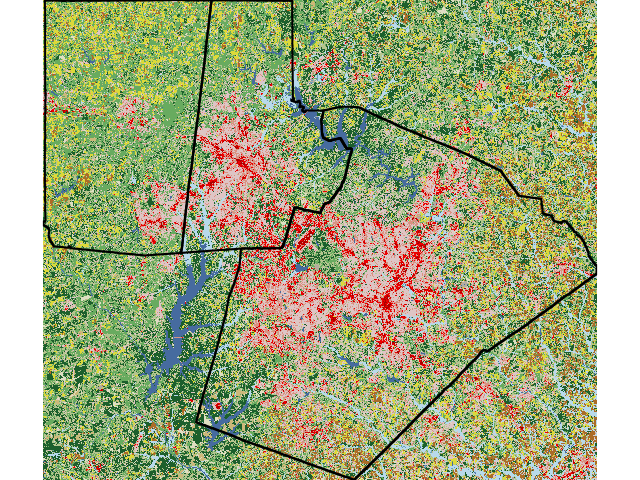

In [8]:
gs.run_command('g.region', vector='counties', align='landuse_2016')

render_map = gj.Map()
render_map.d_rast(map="landuse_2016")
render_map.d_vect(map="counties", fill_color="none", width=2)
render_map.show()

The FUTURES model uses the locations of development and new development to predict when and where new urban growth will occur. This requires longitudinal data on urban land use. We will derive urbanized areas from NLCD dataset for year 2001, 2006, 2011 and 2016 by extracting categories category 21 - 24 into a new binary map where developed is 1, undeveloped 0 and NULL (no data). The NULL area is important in simulating urban growth as it precludes these are from becoming development. For this exercise we assume that water, wetlands and protected areas can not be developed, setting them to NULL.

First we will convert protected areas from vector to raster. We set NULLs to zeros (for simpler raster algebra expression in the next step) using r.null.

In [ ]:
gs.run_command('v.to.rast', input='protected_areas', output='protected_areas', use='val')
gs.run_command('r.null', map='protected_areas', null=0)

render_map = gj.Map()
render_map.d_rast(map="protected_areas")
render_map.d_vect(map="counties", fill_color="none", width=2)
render_map.show()

And then create rasters of developed/undeveloped areas using raster algebra:

In [ ]:
gs.mapcalc("urban_2001 = if(landuse_2001 >= 21 && landuse_2001 <= 24, 1, if(landuse_2001 == 11 || landuse_2001 >= 90 || protected_areas, null(), 0))")
gs.mapcalc("urban_2006 = if(landuse_2006 >= 21 && landuse_2006 <= 24, 1, if(landuse_2006 == 11 || landuse_2006 >= 90 || protected_areas, null(), 0))")
gs.mapcalc("urban_2011 = if(landuse_2011 >= 21 && landuse_2011 <= 24, 1, if(landuse_2011 == 11 || landuse_2011 >= 90 || protected_areas, null(), 0))")
gs.mapcalc("urban_2016 = if(landuse_2016 >= 20 && landuse_2016 <= 24, 1, if(landuse_2016 == 11 || landuse_2016 >= 90 || protected_areas, null(), 0))")

render_map = gj.Map()
render_map.d_rast(map="urban_2016")
render_map.d_vect(map="counties", fill_color="none", width=2)
render_map.show()

FUTURES is a multi-level modelling framework meaning that we model population projections for subregions and assume that these subregions are influenced differently by the factors that influence where development happens. This requires defining subregions for model implementation. For this exercise we use the county level, which is the finest scale of population data that is available to us. We therefore need to convert vectors of counties to a raster with the values of the FIPS attribute which links to population file:


In [ ]:
gs.run_command('v.to.rast', input='counties', type='area', use='attr', attribute_column='value', output='counties')

## Potential submodel
Module [r.futures.potential](https://grass.osgeo.org/grass7/manuals/addons/r.futures.potential.html) implements the POTENTIAL submodel as a part of FUTURES land change model. POTENTIAL is implemented using a set of coefficients that relate a selection of site suitability factors to the probability of a place becoming developed. This is implemented using the parameter table in combination with maps of those site suitability factors (mapped predictors). The coefficients are obtained by conducting multilevel logistic regression in R with package lme4 where the coefficients may vary by county. The best model is selected automatically using dredge function from package MuMIn.

First, we will derive possible predictors of urban growth using GRASS modules.

### Predictors
##### Slope
Slope possibly influences urban growth as steep areas are difficult to build on. We will derive slope in degrees from digital elevation model using r.slope.aspect module:

In [ ]:
gs.run_command('r.slope.aspect', elevation="elevation", slope="slope")

render_map = gj.Map()
render_map.d_rast(map="slope")
render_map.d_vect(map="counties", fill_color="none", width=2)
render_map.show()

#### Distance from lakes/rivers
Distance to lakes or rivers may contribute to an amenity draw where people would like to build a house in a location where they can view water. First we will extract category Open Water from 2016 NLCD dataset:

In [ ]:
gs.mapcalc("water = if(landuse_2016 == 11, 1, null())")

Then we compute the distance to water with module r.grow.distance and set color table to shades of blue:

In [ ]:
gs.run_command('r.grow.distance', input='water', distance='dist_to_water')
gs.run_command('r.colors', flags='en', map='dist_to_water', color='blues')

render_map = gj.Map()
render_map.d_rast(map="dist_to_water")
render_map.d_vect(map="counties", fill_color="none", width=2)
render_map.show()

#### Distance from protected areas
Like water protected areas can attract urban growth as people enjoy living near scenic areas. We will use raster protected of protected areas we already created, but we will set NULL values to zero. We compute the distance to protected areas with module r.grow.distance and set color table from green to red:

In [ ]:
gs.run_command('r.null', map='protected_areas', setnull=0)
gs.run_command('r.grow.distance', input='protected_areas', distance='dist_to_protected')
gs.run_command('r.colors', map='dist_to_protected', color='gyr', flags='e')

render_map = gj.Map()
render_map.d_rast(map="dist_to_protected")
render_map.d_vect(map="counties", fill_color="none", width=2)
render_map.show()

#### Forests
Forest may influence urban growth in different ways. On the one hand it might be costly for developments as tree will need to be removed. On the other hand, people may want to live near forests. We calculate the percentage of forest (0-1) within 1 km2 circular neighborhood to test forest influence, see NLCD categories Forest. We derive the percentage of forest also for year 2001.

In [ ]:
gs.mapcalc("forest = if(landuse_2016 >= 41 && landuse_2016 <= 43, 1, 0)")
gs.mapcalc("forest_2001 = if(landuse_2001 >= 40 && landuse_2001 <= 43, 1, 0)")
gs.run_command('r.neighbors', flags='c', input='forest', output='forest_smooth', size=37, method='average')
gs.run_command('r.neighbors', flags='c', input='forest_2001', output='forest_2001_smooth', size=37, method='average')
gs.run_command('r.colors', map='forest_smooth,forest_2001_smooth', color='ndvi')

render_map = gj.Map()
render_map.d_rast(map="forest_smooth")
render_map.d_vect(map="counties", fill_color="none", width=2)
render_map.show()

#### Distance to main urban centers
Concentrated population and economic activities around main urban centers may be important drivers of development. To calculate this influence we will compute distance to urban centers with more than 200,000 inhabitants:

In [ ]:
gs.run_command('r.grow.distance', input='city_center', distance='dist_to_city_center')

#### Distance to interchanges

We will compute the distance to interchanges:

In [ ]:
gs.run_command('v.to.rast', input='interchanges', type='line', use='val', output='interchanges')
gs.run_command('r.grow.distance', input='interchanges', distance='dist_to_interchanges')

render_map = gj.Map()
render_map.d_rast(map="dist_to_interchanges")
render_map.d_vect(map="counties", fill_color="none", width=2)
render_map.show()

#### Road density
Dense road construction often occurs in suburban areas where much much development occurs in U.S. cities. To capture this influence we can calculate road density based on the road network. We rasterize roads and use a moving window analysis (r.neighbors) to compute road density for a 1 km area:

In [ ]:
gs.run_command('r.neighbors', flags='c', input='roads', output='road_dens', size=37, method='average')

render_map = gj.Map()
render_map.d_rast(map="road_dens")
render_map.d_vect(map="counties", fill_color="none", width=2)
render_map.show()

### Development pressure

Development pressure (computed by [r.futures.devpressure](https://grass.osgeo.org/grass7/manuals/addons/r.futures.devpressure.html)) visualized as 3D surface with binary development map draped as color (orange developed, grey undeveloped).
Development pressure is an important variable in the FUTURES model that is always included as a dynamic variable reinforcing the pressure of past development. We assume that urban development in one location will increase the chance of development in near proximity. New simulated development is incorporated into calculating this development pressure every time step that FUTURES simulates urban growth. To estimate the influence that this local development pressure has, we include the development pressure r.futures.devpressure in our initial model estimates. Development pressure is based on number of neighboring developed cells within a specified search distance, weighted by distance. Its special role in the model allows for path dependent feedback between predicted change and change in subsequent steps.

When gamma increases, development influence decreases more rapidly with distance. Size is half the size of the moving window. When gamma is low, local development influences more distant places. We compute development pressure for development in 2001 for Potential model to estimate how much development pressure influenced new development between 2001 and 2016. Then, we compute it also for 2016 for future projections.

In [ ]:
gs.mapcalc('urban_2001_nonull = if(isnull(urban_2001), 0, urban_2001)')
gs.mapcalc('urban_2016_nonull = if(isnull(urban_2016), 0, urban_2016)')
gs.run_command('r.futures.devpressure', flags='n', input='urban_2001_nonull', output='devpressure_30_05_01_2001 ',
               method='gravity', size=30, gamma=0.5, scaling_factor=0.1)
gs.run_command('r.futures.devpressure', flags='n', input='urban_2016_nonull', output='devpressure_30_05_01_2016',
               method='gravity', size=30, gamma=0.5, scaling_factor=0.1)

render_map = gj.Map()
render_map.d_rast(map="devpressure_30_05_01_2016")
render_map.d_vect(map="counties", fill_color="none", width=2)
render_map.show()

### Rescaling variables

First we will look at the ranges of our predictor variables:

In [ ]:
for name in ['slope', 'dist_to_water', 'dist_to_protected',
             'forest_smooth', 'forest_2001_smooth', 'dist_to_city_center', 'dist_to_interchanges',
             'road_dens', 'devpressure_30_05_01_2001', 'devpressure_30_05_01_2016']:
    minmax = gs.raster_info(name)
    print (name, minmax['min'], minmax['max'])

We will rescale some of our input variables:

In [ ]:
gs.mapcalc("dist_to_water_km = dist_to_water / 1000")
gs.mapcalc("dist_to_protected_km = dist_to_protected / 1000")
gs.mapcalc("dist_to_city_center_km = dist_to_city_center / 1000")
gs.mapcalc("dist_to_interchanges_km = dist_to_interchanges / 1000")
gs.mapcalc("road_dens_perc = road_dens * 100")
gs.mapcalc("forest_smooth_perc = forest_smooth * 100")
gs.mapcalc("forest_2001_smooth_perc = forest_smooth * 100")

### Sampling

To build multilevel statistical model describing the relation between predictors and observed change, we randomly sample predictors and response variable. Our response variable is new development between 2001 and 2016.

In [ ]:
gs.mapcalc("urban_change_01_16 = if(urban_2016 == 1, if(urban_2001 == 0, 1, null()), 0)")

To sample only in the analyzed counties, we will clip the layer:

In [ ]:
gs.mapcalc("urban_change_clip = if(counties, urban_change_01_16)")

render_map = gj.Map()
render_map.d_rast(map="urban_change_clip")
render_map.d_vect(map="counties", fill_color="none", width=2)
render_map.show()

We will sample the predictors and the response variable with more random points in undeveloped areas than in newly developed areas:

In [ ]:
gs.run_command('r.sample.category', input='urban_change_clip', output='sampling',
               sampled='counties,devpressure_30_05_01_2001,slope,road_dens_perc,forest_2001_smooth_perc,dist_to_water_km,dist_to_protected_km,dist_to_city_center_km,dist_to_interchanges_km',
               npoints=[1000, 400])

### Development potential

Now we find best model for predicting urbanization using [r.futures.potential]((https://grass.osgeo.org/grass7/manuals/addons/r.futures.potential.html)) which wraps an R script. We can run R dredge function to find "best" model. We can specify minimum and maximum number of predictors the final model should use.
Because this can be time consuming, for this tutorial we preselected one combination of predictors.

In [ ]:
### with dredge function:
# gs.run_command('r.futures.potential', flags='d', input='sampling',
#                output='potential.csv', columns='counties,devpressure_30_05_01_2001,slope,road_dens_perc,forest_2001_smooth_perc,dist_to_water_km,dist_to_protected_km,dist_to_city_center_km',
#                developed_column='urban_change_clip', subregions_column='counties', min_variables=4)

### pre-selected combination of predictors:
gs.run_command('r.futures.potential', input='sampling', output='potential.csv',
               columns='devpressure_30_05_01_2001,road_dens_perc,forest_2001_smooth_perc,dist_to_water_km,slope,dist_to_interchanges_km',
               developed_column='urban_change_clip', subregions_column='counties')

FUTURES site suitability modeled by r.futures.potential and computed by [r.futures.potsurface](https://grass.osgeo.org/grass7/manuals/addons/r.futures.potsurface.html).
We can now visualize the suitability surface using module r.futures.potsurface. It creates initial development potential (suitability) raster from predictors and model coefficients and serves only for evaluating development Potential model. The values of the resulting raster range from 0 to 1.

In [ ]:
gs.run_command('r.futures.potsurface', input='potential.csv', subregions='counties', output='suitability')
gs.run_command('r.colors', map='suitability', color='byr')

render_map = gj.Map()
render_map.d_rast(map="suitability")
render_map.d_vect(map="counties", fill_color="none", width=2)
render_map.show()

## Demand submodel

Per capita development for one county derived by [r.futures.demand](https://grass.osgeo.org/grass7/manuals/addons/r.futures.demand.html) using logarithmic2 method.
First we will mask out roads so that they don't influence into per capita land demand relation.

In [ ]:
gs.run_command('r.mask', raster='roads', maskcats=0)

We will use r.futures.demand which derives the population vs. development relation. The relation can be linear/logarithmic/logarithmic2/exponential/exponential approach. Look for examples of the different relations in the manual.

linear: y = A + Bx  
logarithmic: y = A + Bln(x)  
logarithmic2: y = A + B * ln(x - C)        (requires SciPy)  
exponential: y = Ae^(BX)  
exp_approach: y = (1 - e^(-A(x - B))) + C        (requires SciPy)  

The format of the input population CSV files is described in the manual. It is important to have synchronized categories of subregions and the column headers of the CSV files (in our case FIPS number). We can simply generate the list of years (for which demand is computed)with this Python code:

In [ ]:
years = ','.join([str(i) for i in range(2016, 2039)])

Then we can create the DEMAND file:

In [ ]:
gs.run_command('r.futures.demand', development='urban_2001,urban_2006,urban_2011,urban_2016',
               subregions='counties', observed_population='population_trend.csv',
               projected_population='population_projection.csv',
               simulation_times=years, plot='plot_demand.png', demand='demand.csv',
               separator='comma', method='logarithmic,logarithmic2,exp_approach')
Image('plot_demand.png')

## Patch calibration

We derive patches of new development by comparing historical and latest development using [r.futures.calib](https://grass.osgeo.org/grass7/manuals/addons/r.futures.calib.html).
We can keep only patches with minimum size 2 cells (1800 = 2 x 30 x 30 m). We will derive patch libraries for each county separately (flag -s).

In [ ]:
gs.run_command('r.futures.calib', development_start='urban_2001', development_end='urban_2016',
               subregions='counties', patch_sizes='patches.csv', patch_threshold=1800, flags='ls')

When you are finished, remove the mask as it is not needed for the next steps.

In [ ]:
gs.run_command('r.mask', flags='r')

We obtained a file patches.csv (used later in the PGA) - a patch size distribution file - containing sizes of all found patches.
We can check the content of the patch library CSV file, first line is header, the rest are patch sizes in number of cells:

In [ ]:
!head patches.csv

We can look at the distribution of the patch sizes for one of the counties:

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
subregion = 0
with open('patches.csv') as f:
    patches = [patch.split(',')[subregion] for patch in f.readlines()[1:]]
    patches = [int(patch) for patch in patches if patch]
plt.hist(patches, bins='auto', range = (0, 500))
plt.xlim(0,500)
plt.show()

We will run the calibration to get best parameters of patch shape (can be time consuming).

In [ ]:
gs.run_command('r.futures.calib', development_start='urban_2001', development_end='urban_2016',
               subregions='counties', patch_sizes='patches.csv', patch_threshold=1800, flags='s',
               repeat=5, calibration_results='calib.csv', nprocs=5,
               predictors='road_dens_perc,forest_smooth_perc,dist_to_water_km,slope,dist_to_interchanges_km',
               devpot_params='potential.csv', development_pressure='devpressure_30_05_01_2016',
               n_dev_neighbourhood=30, development_pressure_approach='gravity', gamma=0.5, scaling_factor=0.1,
               demand='demand.csv', discount_factor=[0.1], compactness_mean=[0, 0.2, 0.4],
               compactness_range=[0.1], num_neighbors=4, seed_search='probability', random_seed=1)

We will look at the calibration file. First line shows the parameters with lowest combined error:

In [ ]:
!cat calib.csv

We will save the values from the first line to use them in the FUTURES call:

In [ ]:
with open('calib.csv') as f:
    disc_factor, comp_mean, comp_range = f.readlines()[1].split(',')[:3]

## FUTURES simulation

Now we have all the inputs necessary for running [r.futures.pga](https://grass.osgeo.org/grass7/manuals/addons/r.futures.pga.html):

In [ ]:
gs.run_command('r.futures.pga', subregions='counties', developed='urban_2016',
               predictors='road_dens_perc,forest_smooth_perc,dist_to_water_km,slope,dist_to_interchanges_km',
               devpot_params='potential.csv', development_pressure='devpressure_30_05_01_2016',
               n_dev_neighbourhood=30, development_pressure_approach='gravity', gamma=0.5, scaling_factor=0.1,
               demand='demand.csv', discount_factor=disc_factor, compactness_mean=comp_mean, compactness_range=comp_range,
               patch_sizes='patches.csv', num_neighbors=4, seed_search='probability', random_seed=1,
               output='final', output_series='step')

In [ ]:
render_map = gj.InteractiveMap()
render_map.add_raster("final", opacity=0.8)
return render_map.show()


We will patch projected development into 2016 NLCD and visualize it. We need to restrict the region because the file size is too large.

In [ ]:
gs.mapcalc("landuse_2038 = if(isnull(counties),null() , if (isnull(final), landuse_2016, if(final >=1, 21, landuse_2016)))")
gs.run_command('r.colors', map='landuse_2038', raster='landuse_2016')

render_map = gj.InteractiveMap()
render_map.add_raster("landuse_2038", opacity=0.8)
return render_map.show()

## Postprocessing of multiple stochastic runs

We can run multiple stochastic simulations with [r.futures.parallelpga](https://grass.osgeo.org/grass7/manuals/addons/r.futures.parallelpga.html):

In [ ]:
gs.run_command('r.futures.parallelpga', subregions='counties', developed='urban_2016',
               predictors='road_dens_perc,forest_smooth_perc,dist_to_water_km,slope,dist_to_interchanges_km',
               devpot_params='potential.csv', development_pressure='devpressure_30_05_01_2016',
               n_dev_neighbourhood=30, development_pressure_approach='gravity', gamma=0.5, scaling_factor=0.1,
               demand='demand.csv', discount_factor=disc_factor, compactness_mean=comp_mean, compactness_range=comp_range,
               patch_sizes='patches.csv', num_neighbors=4, seed_search='probability',
               output='final', nprocs=2, repeat=5)

In this example we postprocess data from multiple stochastic runs to see which land category is most impacted by urban growth.

In [ ]:
import numpy as np
 
# get information about how many cells there are of each land use category, use r.stats
def stats(raster):
    developed = agriculture = forest = other = 0
    res = gs.read_command('r.stats', flags='cn', input=raster, quiet=True).strip()
    for line in res.strip().splitlines():
        cat, cells = line.split()
        cat = int(cat)
        cells = int(cells)
        # developed
        if 21 <= cat <= 24:
            developed += cells
        # agriculture
        elif cat == 81 or cat == 82:
            agriculture += cells
        # forest
        elif 41 <= cat <= 43:
            forest += cells
        # other land use
        else:
            other += cells
    return developed, agriculture, forest, other

# list maps computed by r.futures.parallelpga for one scenario
current_mapset = gs.gisenv()['MAPSET']
# put the name you are using for the scenarios in the pattern option 
maps = gs.list_grouped('raster', pattern="final_run*")[current_mapset]
developed = []
forest = []
agriculture = []
other = []
for each in maps:
    # compute landcover in 2038 by updating landcover 2011 with the simulation results:
    gs.mapcalc("landuse_2038_{name} = if(isnull({name}), landuse_2016, if({name} >=1, 21, landuse_2016))".format(name=each))
    dev, agr, forst, othr = stats("landuse_2038_{name}".format(name=each))
    developed.append(dev)
    agriculture.append(agr)
    forest.append(forst)
    other.append(othr)

dev_orig, agr_orig, forest_orig, other_orig = stats('landuse_2016')
 
# convert to NumPy arrays
forest = np.array(forest)
agriculture = np.array(agriculture)
other = np.array(other)
developed = np.array(developed)

In [ ]:
%matplotlib inline
plt.style.use('ggplot')
plt.bar(np.arange(3), [agr_orig - np.mean(agriculture),
                      forest_orig - np.mean(forest), other_orig - np.mean(other)])

plt.ylabel('# cells')
plt.title('Loss of land')
plt.xticks(np.arange(3), ('Agriculture', 'Forest', 'Other'))
plt.show()